# **Volatility Skew Trading**

Volatility skew is a well-known phenomenon in the options market that refers to the difference in implied volatility (IV) between out-of-the-money (OTM) calls and puts. This skew arises from market sentiment, supply and demand imbalances, and behavioral factors — most notably loss aversion.

## Why Trade the Skew?

Options were originally introduced as hedging instruments, and many investors are willing to overpay for downside protection. This behavioral bias is well described by **Prospect Theory** (Kahneman & Tversky, 1979), which suggests that individuals tend to overweight small-probability events and exhibit strong aversion to losses.

As options traders, we can exploit these persistent mispricings by constructing volatility skew trading strategies, aiming to profit when market-implied fears (e.g., demand for puts) fail to materialize. These strategies typically assume that the pricing dislocation is temporary or exaggerated relative to actual realized outcomes.

The notebook is structured as follows:

1. [Read SPX Options Data](#read_data)
2. [Plot the Implied Volatility Skew](#plot_iv)
3. [Remove illiquid Options](#illiquid)
4. [Build the Synthetic 30-DTE Skew](#skew)
5. [Implement Trading Strategies](#construct-strategy)
    - [Strategy 1: Mean reversion on the Skew](#signal-zscore)
        - [Signal 1: Fixed absolute skew threshold](#signal-meanrevert)
        - [Signal 2: Rolling zscore of the Skew](#signal-meanrevert)
    - [Strategy 2: Momentum on the Skew](#signal-zscore)
        - [Signal 1: Skew Slope](#signal-meanrevert)
        - [Signal 2: MACD Style](#signal-meanrevert)
    - [Strategy 3: Hybrid Mean reversion with Momentum and VIX Filter](#signal-zscore)
6. [Compare Backtests](#compare-backtests)
7. [Conclusion](#conclusion)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from utility import reshape_options_long_to_wide, reshape_options_wide_to_long
from config.constants import OPTION_TYPES

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# **Read SPX Options Data**

In this notebook we are going to consider the entire options chain, namely all strikes and expiries for each date in the year 2023.

In [2]:
file = "data/intermediate/full_spx_options_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask
date,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,8.17536,3041.37,0.03,1.0,7.0,2846.8,2848.3,0.0,0.05
2023-01-04,1200.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,7.06724,0.00,0.00,1.0,0.0,2646.8,2648.3,0.0,0.05
2023-01-04,1400.0,3853.39,0.0,2023-01-04,1.00000,-0.00025,NaN,6.13893,0.00,0.00,0.0,0.0,2427.6,2471.0,0.0,0.05
2023-01-04,1600.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,5.33125,2417.29,0.00,1.0,0.0,2246.8,2248.3,0.0,0.05
2023-01-04,1800.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,4.61644,0.00,0.00,0.0,0.0,2046.8,2048.3,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,7200.0,4772.17,2184.0,2029-12-21,0.29633,-1.00000,0.17401,NaN,0.00,0.00,0.0,0.0,286.8,366.8,1550.9,1630.90
2023-12-29,7400.0,4772.17,2184.0,2029-12-21,0.27129,-1.00000,0.17063,NaN,0.00,0.00,0.0,0.0,245.4,325.4,1669.0,1749.00
2023-12-29,7600.0,4772.17,2184.0,2029-12-21,0.24709,-1.00000,0.16688,NaN,0.00,0.00,0.0,0.0,208.7,288.7,1791.8,1871.80


# **Plot the Implied Volatility Skew**

We now examine how the implied volatility skew evolves as time to maturity decreases, focusing on the first EOM (End-of-Month) options contracts.

In [3]:
expiry = "2023-01-31"

eom_options = options[options["expiry"] == expiry].copy()
eom_options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask
date,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.35367,0.00,0.00,0.0,0.0,2845.7,2854.60,0.0,0.05
2023-01-04,1200.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.17498,2623.64,0.10,1.0,10.0,2643.4,2651.80,0.0,0.05
2023-01-04,1400.0,3853.39,27.0,2023-01-31,1.00000,-0.00031,NaN,1.02388,2377.30,0.07,1.0,2.0,2444.1,2453.70,0.0,0.05
2023-01-04,1500.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,0.95679,0.00,0.10,0.0,1.0,2347.4,2355.90,0.0,0.05
2023-01-04,1600.0,3853.39,27.0,2023-01-31,1.00000,-0.00029,NaN,0.89294,2183.32,0.05,2.0,2.0,2244.6,2253.10,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,5000.0,4077.16,0.0,2023-01-31,0.00045,-0.91977,1.34915,2.62827,0.03,967.80,80.0,83.0,0.0,0.05,920.7,929.20
2023-01-31,5100.0,4077.16,0.0,2023-01-31,0.00000,-0.91545,1.46973,2.89948,0.15,0.00,10.0,0.0,0.0,0.05,1020.7,1029.20
2023-01-31,5200.0,4077.16,0.0,2023-01-31,0.00063,-0.91219,1.58868,3.17182,0.65,0.00,1.0,0.0,0.0,0.05,1120.7,1129.20


In [4]:
def compute_iv_smile(options, dte, atm_strike_range=1000):
    options_red = options.loc[options["dte"] == dte].copy()

    atm_idx = (options_red["strike"] - options_red["underlying_last"]).abs().argmin()
    atm_strike = options_red.iloc[atm_idx]["strike"]
    options_red["atm_strike"] = atm_strike

    # Keep only strikes within ±1000 of ATM
    options_red = options_red[((options_red['strike'] - options_red['atm_strike']).abs() <= atm_strike_range)]

    options_red['iv_smile'] = np.where(
        options_red['strike'] < atm_strike,
        options_red['p_iv'],
        np.where(
            options_red['strike'] > atm_strike,
            options_red['c_iv'],
            0.5 * (options_red['c_iv'] + options_red['p_iv'])  # At-the-money
        )
    )
    options_red = options_red.set_index("strike")

    return options_red["iv_smile"]

In [5]:
# Extract unique DTEs available
available_dtes = sorted(eom_options['dte'].unique())

# Extratc DTEs closest to 30, 15 and 1 resp.
dte_30 = max([d for d in available_dtes if d <= 30], default=None)
dte_15 = min(available_dtes, key=lambda x: abs(x - 15))
dte_1 = min([d for d in available_dtes if d > 1], default=None)

target_dtes = [int(d) for d in [dte_30, dte_15, dte_1] if d is not None]

iv_smiles = {}
for dte in target_dtes:
    iv_smile = compute_iv_smile(eom_options, dte)
    iv_smiles[dte] = iv_smile

In [6]:
def plot_iv_smiles(iv_smiles, ticker):
    plt.figure(figsize=(12, 6))

    for dte, iv_smile in iv_smiles.items():
        if iv_smile is not None and not iv_smile.empty:
            plt.scatter(iv_smile.index, iv_smile.values, marker='o', label=int(dte))

    plt.xlabel('Strike', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Implied Volatility Smiles for {ticker} Options', fontsize=16)
    plt.legend(title="Days to Expiry", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

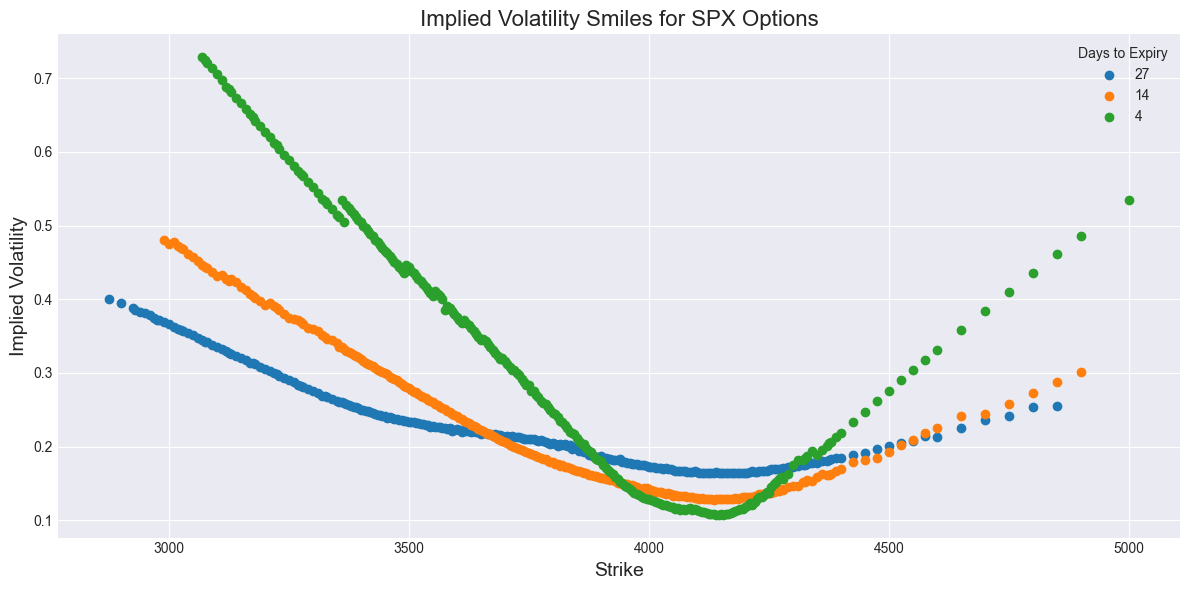

In [7]:
plot_iv_smiles(iv_smiles, "SPX")

For larger DTEs, the implied volatility skew takes the shape of a smirk, with moderately elevated IVs for OTM puts. As DTE approaches zero, the skew becomes much steeper, reflecting increased sensitivity to short-term downside risk.

# **Remove illiquid options**

To ensure more realistic and robust backtest results, we remove illiquid options. These contracts typically suffer from wide bid-ask spreads and poor fill quality, making them expensive to trade and potentially eroding any theoretical edge.

In [8]:
options = reshape_options_wide_to_long(options)
options.head()

,strike,underlying_last,dte,expiry,delta,iv,last,volume,bid,ask,option_type
date,,,,,,,,,,,
2023-01-04,100.0,3853.39,345.0,2023-12-15,1.0000,NaN,3698.92,2.0,3690.0,3703.4,C
2023-01-04,100.0,3853.39,345.0,2023-12-15,-0.0005,1.11594,0.07,1.0,0.0,0.1,P
2023-01-04,200.0,3853.39,16.0,2023-01-20,1.0000,NaN,3618.19,1.0,3647.0,3650.0,C
2023-01-04,200.0,3853.39,44.0,2023-02-17,1.0000,NaN,3647.38,1.0,3631.2,3643.6,C
2023-01-04,200.0,3853.39,72.0,2023-03-17,1.0000,NaN,3587.35,1.0,3628.7,3638.0,C


## Volume Filter

Since Open Interest is not available in our dataset, we use daily traded **volume** as a proxy for option contract liquidity. While not a perfect substitute, volume provides a reasonable indication of market activity and tradability. 

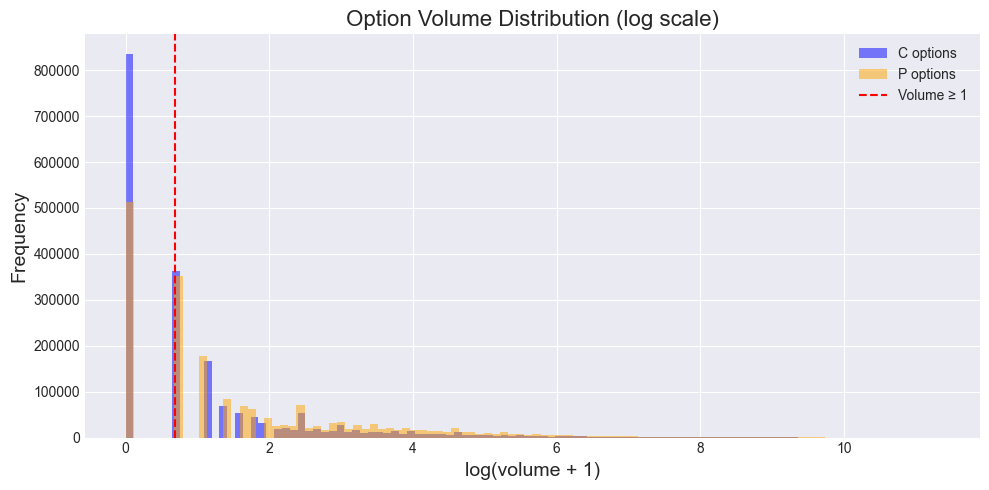

In [9]:
# Add 1 to avoid log(0), then take log
log_volumes = (options["volume"] + 1).apply(np.log)

plt.figure(figsize=(10, 5))

for opt_type, color in zip(OPTION_TYPES, ["blue", "orange"]):
    subset = options[options["option_type"] == opt_type]
    log_volumes = (subset["volume"] + 1).apply(np.log)
    log_volumes.hist(bins=100, alpha=0.5, label=f"{opt_type} options", color=color)

plt.axvline(np.log(2), color='r', linestyle='--', label='Volume ≥ 1')
plt.title("Option Volume Distribution (log scale)", fontsize=16)
plt.xlabel("log(volume + 1)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We remove options with very low volume (e.g., volume < 1), as these are likely illiquid and may not reflect reliable pricing or realistic execution.

In [10]:
volume_threshold = 1

## Bid-Ask Spread Filter

The bid-ask spread is a key measure of transaction cost and liquidity. Options with wide spreads are harder to trade efficiently and may reflect stale or unreliable pricing.

First we drop 0 ask and bid values, as they indicate that no trading occured at a particular date for a specific option.


Now we filter out options where the **relative bid-ask spread** exceeds a threshold (e.g., 25%), defined as:

$$
\text{Relative Spread} = \frac{\text{Ask} - \text{Bid}}{0.5 \times (\text{Ask} + \text{Bid})}
$$

In [11]:
options["mid"] = 0.5 * (options["bid"] + options["ask"])
options["rel_spread"] = (options["ask"] - options["bid"]) / options["mid"]

options[["bid", "ask", "mid", "rel_spread"]]

,bid,ask,mid,rel_spread
date,,,,
2023-01-04,3690.0,3703.4,3696.70,0.003625
2023-01-04,0.0,0.1,0.05,2.000000
2023-01-04,3647.0,3650.0,3648.50,0.000822
2023-01-04,3631.2,3643.6,3637.40,0.003409
2023-01-04,3628.7,3638.0,3633.35,0.002560
...,...,...,...,...
2023-12-29,3.5,13.0,8.25,1.151515
2023-12-29,6348.4,6435.3,6391.85,0.013595
2023-12-29,6033.5,6087.7,6060.60,0.008943


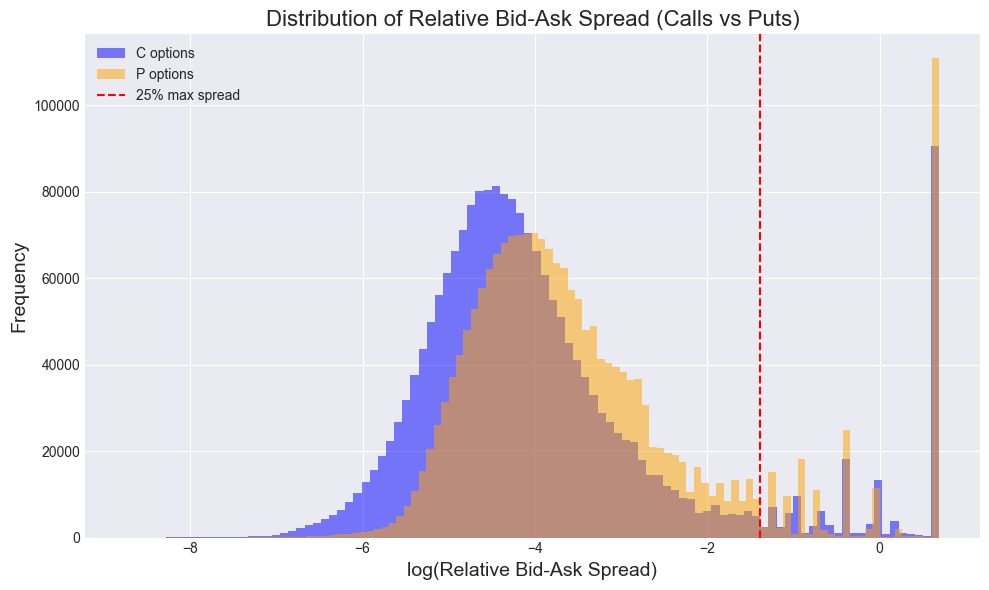

In [12]:
plt.figure(figsize=(10, 6))

for opt_type, color in zip(OPTION_TYPES, ["blue", "orange"]):
    subset = options[options["option_type"] == opt_type]
    log_rel_spread = (subset["rel_spread"] + 1e-6).apply(np.log)
    log_rel_spread.hist(bins=100, alpha=0.5, label=f"{opt_type} options", color=color)

plt.axvline(np.log(0.25), color='red', linestyle='--', label="25% max spread")
plt.xlabel("log(Relative Bid-Ask Spread)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Relative Bid-Ask Spread (Calls vs Puts)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A threshold of 25% seems a reasonble choice for removing too large bid-ask spreads.

In [13]:
spread_threshold = 0.25

## Moneyness filter

We filter options based on their moneyness (strike / underlying price) to focus on contracts with meaningful market activity. Deep ITM or far OTM options are often illiquid or mispriced, so we retain only those within a reasonable band (e.g., 0.8 to 1.2).

In [14]:
options["moneyness"] = options["strike"] / options["underlying_last"]

options["moneyness_bin"] = pd.cut(
    options["moneyness"],
    bins=np.arange(0.5, 1.6, 0.05),
    include_lowest=True
)

avg_vol = (
    options.groupby(["option_type", "moneyness_bin"])["volume"]
    .mean()
    .reset_index()
)

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_21728/1300706182.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  options.groupby(["option_type", "moneyness_bin"])["volume"]


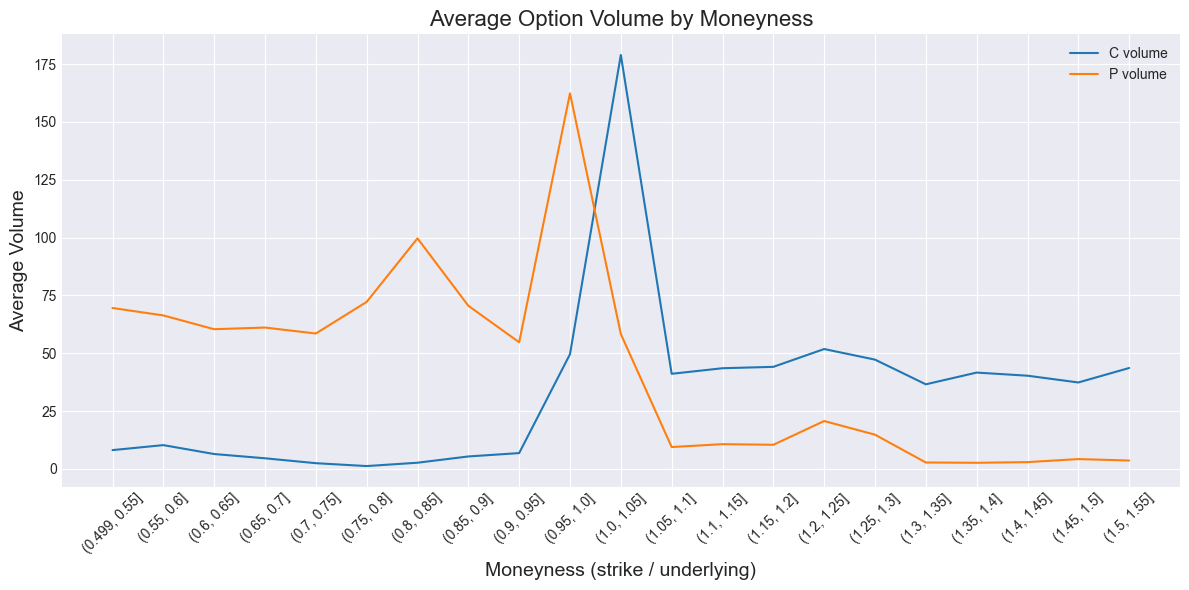

In [15]:
plt.figure(figsize=(12, 6))

for option_type in OPTION_TYPES:
    subset = avg_vol[avg_vol["option_type"] == option_type]
    plt.plot(
        subset["moneyness_bin"].astype(str),
        subset["volume"],
        label=f"{option_type} volume"
    )

plt.xticks(rotation=45)
plt.xlabel("Moneyness (strike / underlying)", fontsize=14)
plt.ylabel("Average Volume", fontsize=14)
plt.title("Average Option Volume by Moneyness", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We observe that average volume for OTM Calls drops sharply beyond a moneyness of 1.2, indicating low liquidity. For OTM Puts, volume remains relatively high down to a moneyness of 0.8, but falls off below that. Therefore, we retain options within the band [0.8, 1.2] to focus on the most liquid and tradeable strikes.

In [16]:
moneynes_lower_band = 0.8
moneynes_upper_band = 1.2

## Apply the filters

In [17]:
n = len(options)

# Volume filter
options = options[options["volume"] >= volume_threshold].copy()

# Bid-Ask filter
options = options[(options["bid"] > 0) & (options["ask"] > 0)].copy()
options = options[options["rel_spread"] <= spread_threshold].copy()

# Moneyness filter
options = options[(options["moneyness"] >= moneynes_lower_band) &
                  (options["moneyness"] <= moneynes_upper_band)]

pct_dropped = 100 * (1 - len(options) / n)
print(f"Percentage of observations dropped across all filters: {pct_dropped:.2f}%")

Percentage of observations dropped across all filters: 50.65%


# **Build the Synthetic 30-DTE Skew**

To measure skew consistently, we compare the implied volatilities of an OTM put and call at a fixed 30-day time-to-expiry. Since shorter-dated options tend to show steeper skews and longer-dated ones flatter, holding expiry constant allows for meaningful comparisons over time.

We construct a synthetic 30-DTE skew by interpolating between the two closest expiries bracketing 30 days. While not directly tradable, this synthetic skew mirrors what institutional desks track and isolates true shifts in sentiment from calendar-driven effects.

## Compute Interpolated 30-DTE IVs

To construct the 30-day implied volatilities, we interpolate between the two expiries that bracket 30 DTE — one below $T_1$ and one above $T_2$. For choosing the strike, we are going to use a method called **delta targeting**, which consists in choosing the strikes such that the delta is ±0.25.

In addition, instead of interpolating the full volatility smile, we focus only on the options of interest:

- A 25-delta **put** and **call**, denoted: $IV^{Put}_{30DTE}$, $IV^{Call}_{30DTE}$
  
- An **ATM IV**, estimated as the average of call and put IVs with delta ≈ 0


The interpolation is performed in total variance space using:

$$
V_* = V_1 + \frac{T_* - T_1}{T_2 - T_1} \cdot (V_2 - V_1)
\qquad
IV_* = \sqrt{\frac{V_*}{T_*}}
$$

Where:

$$
V_i = IV_i^2 \cdot \frac{DTE_i}{252}
$$

This gives us smooth and consistent synthetic 30-DTE IVs for measuring skew over time.

In [18]:
def interp_iv(df_lower, df_upper, T1, T2, target_dte, target_delta):
    """
    Interpolate IV at a given delta and target DTE using two expiry slices.
    """
    row1 = df_lower.iloc[(df_lower['delta'] - target_delta).abs().argmin()]
    
    if T2 == T1:
        return row1.iv  # no interpolation needed

    row2 = df_upper.iloc[(df_upper['delta'] - target_delta).abs().argmin()]
    
    t1, t2 = T1 / 252, T2 / 252
    V1 = row1.iv**2 * t1
    V2 = row2.iv**2 * t2

    t_target = target_dte / 252
    V_target = V1 + (t_target - t1) / (t2 - t1) * (V2 - V1)

    if V_target <= 0 or t_target <= 0:
        return np.nan
    
    return np.sqrt(V_target / t_target)

## Compute the 25-Delta Skew

To systematically measure asymmetry in implied volatility across strikes, we compute the **25-delta skew** — a standard metric in volatility trading.

Instead of relying on fixed moneyness levels (e.g., 90% / 110%), we use **delta targeting**, selecting the OTM put and call with deltas near -0.25 and +0.25. This approach is more robust, as delta accounts for the strike, expiry, volatility, and underlying price — resulting in a consistent and normalized strike selection.

The absolute 25-delta skew is given by:

$$
25\Delta\ \text{Skew} = IV_{25\Delta\,Put} - IV_{25\Delta\,Call}
$$

Lastly, we normalize the absolute skew by the ATM IV to obtain a scale-invariant measure, allowing for fair comparisons across time, assets, and expiries — even in different volatility regimes.
$$
\text{Normalized Skew} = \frac{IV_{25\Delta\,Put} - IV_{25\Delta\,Call}}{IV_{ATM}}
$$

In [19]:
def compute_skew(iv_put, iv_call, iv_atm):
    skew_abs = iv_put - iv_call
    skew_norm = skew_abs / iv_atm if iv_atm and not np.isnan(iv_atm) else np.nan
    return skew_abs, skew_norm

## Compute the Synthetic 30-DTE 25-Delta Skew

Now we bring everything together by applying the previous steps for each trading day to compute the synthetic skew.

For each date *t*, we proceed as follows:

**Step 1:** Extract the two expiries closest to the 30-day target — one below and one above.

**Step 2:** For each expiry, filter the options to find the contracts with deltas closest to ±0.25 — representing the 25-delta OTM **put** and **call**.

**Step 3:** Interpolate the implied volatilities of these 25-delta options in total variance space to obtain a synthetic 30-DTE IV for both put and call.

**Step 4:** Repeat the interpolation for **ATM options**, using a target delta of 0 for both puts and calls.

**Step 5:** Compute the **ATM IV** as the average of the interpolated ATM call and put IVs.

**Step 6:** Compute the skew:
- **Absolute skew**: $\text{Skew}_{\text{abs}} = IV_{\text{put}} - IV_{\text{call}}$
- **Normalized skew**: $\text{Skew}_{\text{norm}} = \frac{IV_{\text{put}} - IV_{\text{call}}}{IV_{\text{ATM}}}$

In [20]:
def compute_synthetic_skew(options, 
                           target_dte=30, 
                           target_delta_otm=0.25,
                           target_delta_atm=0.5):
    results = []

    for date, df in options.groupby("date"):
        exps = df['dte'].dropna().unique()
        below = exps[exps <= target_dte]
        above = exps[exps >= target_dte]
        if not len(below) or not len(above):
            continue

        T1, T2 = below.max(), above.min()
        df1, df2 = df[df['dte'] == T1], df[df['dte'] == T2]
        
        # OTM Put IV 
        iv_put  = interp_iv(df1[df1.option_type == 'P'], 
                            df2[df2.option_type == 'P'], 
                            T1, 
                            T2, 
                            target_dte, 
                            -target_delta_otm)
        # OTM Call IV 
        iv_call = interp_iv(df1[df1.option_type == 'C'], 
                            df2[df2.option_type == 'C'], 
                            T1, 
                            T2, 
                            target_dte, target_delta_otm)

        # ATM Put & Call IV
        iv_atm_put  = interp_iv(df1[df1.option_type == 'P'],
                                df2[df2.option_type == 'P'], 
                                T1, 
                                T2, 
                                target_dte, 
                                -target_delta_atm)
        iv_atm_call = interp_iv(df1[df1.option_type == 'C'], 
                                df2[df2.option_type == 'C'], 
                                T1, 
                                T2, 
                                target_dte, 
                                target_delta_atm)
        iv_atm = np.nanmean([iv_atm_call, iv_atm_put])

        skew_abs, skew_norm = compute_skew(iv_put, iv_call, iv_atm)

        results.append({
            'date':       date,
            'iv_put_30':  iv_put,
            'iv_call_30': iv_call,
            'iv_atm_30':  iv_atm,
            'skew_abs':   skew_abs,
            'skew_norm':  skew_norm
        })

    return pd.DataFrame(results).set_index('date').sort_index()

In [21]:
synthetic_skew = compute_synthetic_skew(options, target_dte=30)
synthetic_skew

,iv_put_30,iv_call_30,iv_atm_30,skew_abs,skew_norm
date,,,,,
2023-01-04,0.230950,0.186920,0.209115,0.044030,0.210554
2023-01-05,0.233239,0.189412,0.211655,0.043827,0.207068
2023-01-06,0.211219,0.179939,0.195825,0.031281,0.159737
2023-01-09,0.218010,0.188590,0.200680,0.029420,0.146602
2023-01-10,0.211920,0.180930,0.193040,0.030990,0.160537
...,...,...,...,...,...
2023-12-22,0.118545,0.103150,0.106070,0.015396,0.145145
2023-12-26,0.119700,0.100920,0.106075,0.018780,0.177045
2023-12-27,0.114400,0.097640,0.101930,0.016760,0.164427


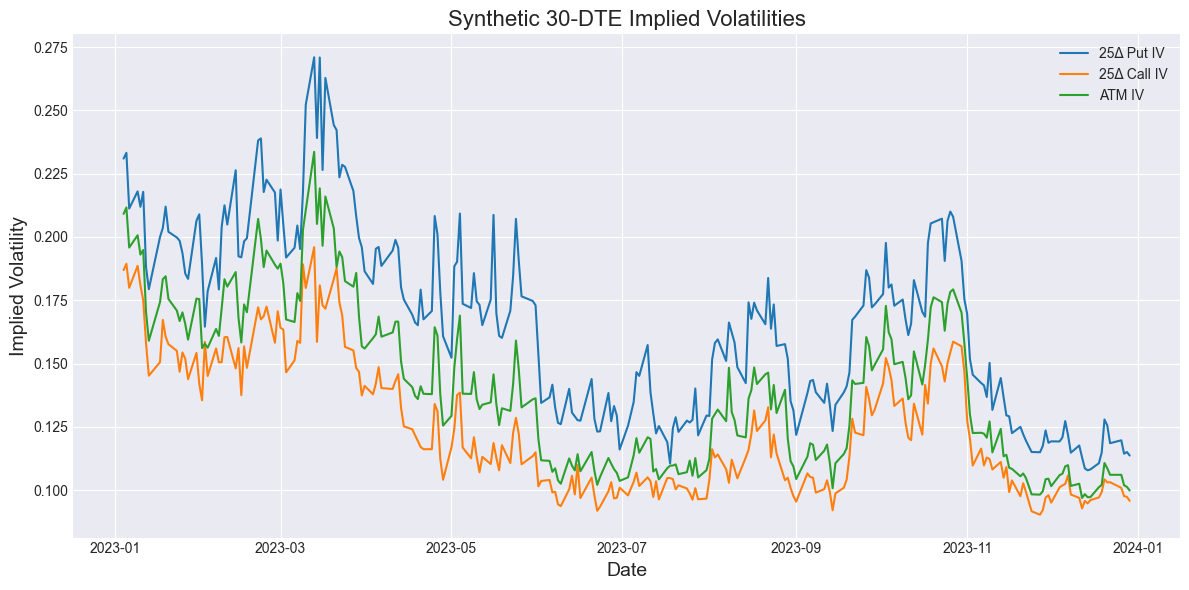

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(synthetic_skew.index, synthetic_skew['iv_put_30'], label='25Δ Put IV')
plt.plot(synthetic_skew.index, synthetic_skew['iv_call_30'], label='25Δ Call IV')
plt.plot(synthetic_skew.index, synthetic_skew['iv_atm_30'], label='ATM IV')

plt.title('Synthetic 30-DTE Implied Volatilities', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Implied Volatility', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The relative ordering aligns with the typical smirk-shaped skew observed in equity index options, where the **IV of the OTM put is highest**, followed by the **ATM IV**, and finally the **OTM call IV as the lowest**. All three series generally move in the same direction, which is expected given their shared dependence on overall market volatility. 

Notably, the **OTM put IV exhibits greater variability**, reflecting its heightened sensitivity to downside risk and demand for crash protection.

In [23]:
synthetic_skew[["iv_put_30", "iv_atm_30", "iv_call_30"]].corr()

,iv_put_30,iv_atm_30,iv_call_30
iv_put_30,1.000000,0.976074,0.921216
iv_atm_30,0.976074,1.000000,0.973665
iv_call_30,0.921216,0.973665,1.000000


In [24]:
synthetic_skew[["iv_put_30", "iv_atm_30", "iv_call_30"]].std()

iv_put_30     0.036744
iv_atm_30     0.031646
iv_call_30    0.026354
dtype: float64

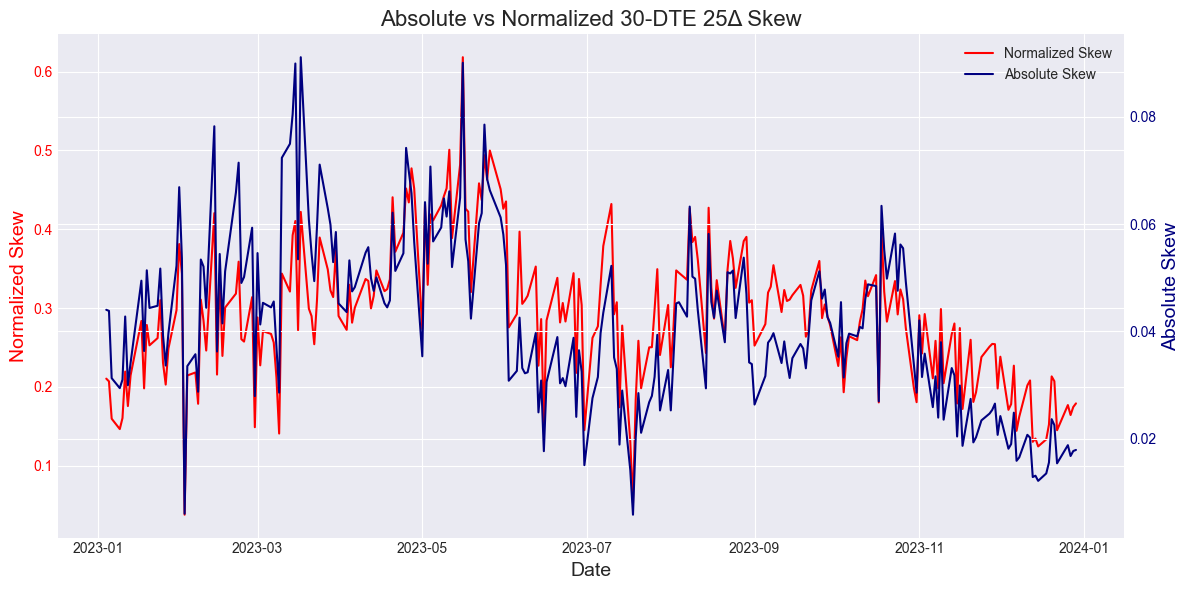

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(synthetic_skew['skew_norm'], color="red", label="Normalized Skew")
ax1.set_ylabel("Normalized Skew", color="red", fontsize=14)
ax1.tick_params(axis='y', labelcolor="red")

ax2 = ax1.twinx()
ax2.plot(synthetic_skew['skew_abs'], color="navy", label="Absolute Skew")
ax2.set_ylabel("Absolute Skew", color="navy", fontsize=14)
ax2.tick_params(axis='y', labelcolor="navy")

ax1.set_title("Absolute vs Normalized 30-DTE 25Δ Skew", fontsize=16)
ax1.set_xlabel("Date", fontsize=14)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()

As shown, the absolute skew is more sensitive to changes in volatility regimes and exhibits higher noise over time — particularly during the first three months of heightened volatility. In contrast, the normalized skew remains more stable, making it better suited for generating consistent and reliable trading signals.

5. [Implement Trading Strategies](#construct-strategy)
    - [Strategy 1: Mean reversion on the Skew](#signal-zscore)
        - [Signal 1: Fixed absolute skew threshold](#signal-meanrevert)
        - [Signal 2: Rolling zscore of the Skew](#signal-meanrevert)
    - [Strategy 2: Momentum on the Skew](#signal-zscore)
        - [Signal 1: Skew Slope](#signal-meanrevert)
        - [Signal 2: MACD Style](#signal-meanrevert)
    - [Strategy 3: Hybrid Mean reversion with Momentum and VIX Filter](#signal-zscore)

5. [Backtest with Walf Forward including risk management constraints](#construct-strategy)

<a id='strat'></a>
# **Implement Trading Strategies**

We now leverage the skew metrics computed earlier to generate trading signals. In the first part, we use the skew as a **predictive signal to trade the underlying** (e.g., SPY), treating the skew as a proxy for market sentiment.

In the second part, we take it one step further by using the skew signal to trade a realistic options position that closely replicates the theoretical 30-DTE 25-delta skew, such as a **risk reversal** or **put spread strategy**, using liquid strikes and expiries.

## **Signal 1: Skew Z-Score on SPY**

The **implied volatility skew** tends to exhibit **mean-reverting behavior**, especially during shifts in market sentiment. We can exploit this by identifying **extreme skew levels** using a **Z-score**, and triggering trades in the **underlying asset** accordingly.

Since the **SPX index** is not directly tradeable, we use the **SPY ETF** as a **liquid proxy** to enter and manage positions.

In [26]:
spy = yf.download("SPY", start=options.index[0], end=options.index[-1])
spy

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_21728/4238085849.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=options.index[0], end=options.index[-1])
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2023-01-04,371.011047,373.060614,367.375950,370.450299,85934100
2023-01-05,366.776520,369.154787,366.177122,369.038778,76970500
2023-01-06,375.187439,376.318583,366.805485,369.899159,104189600
2023-01-09,374.974762,380.620775,374.791101,377.401386,73978100
2023-01-10,377.604462,377.672143,373.437647,374.385101,65358100
...,...,...,...,...,...
2023-12-21,463.942047,464.216858,460.153548,462.597405,86667500
2023-12-22,464.874420,466.572378,462.960567,465.080521,67126600


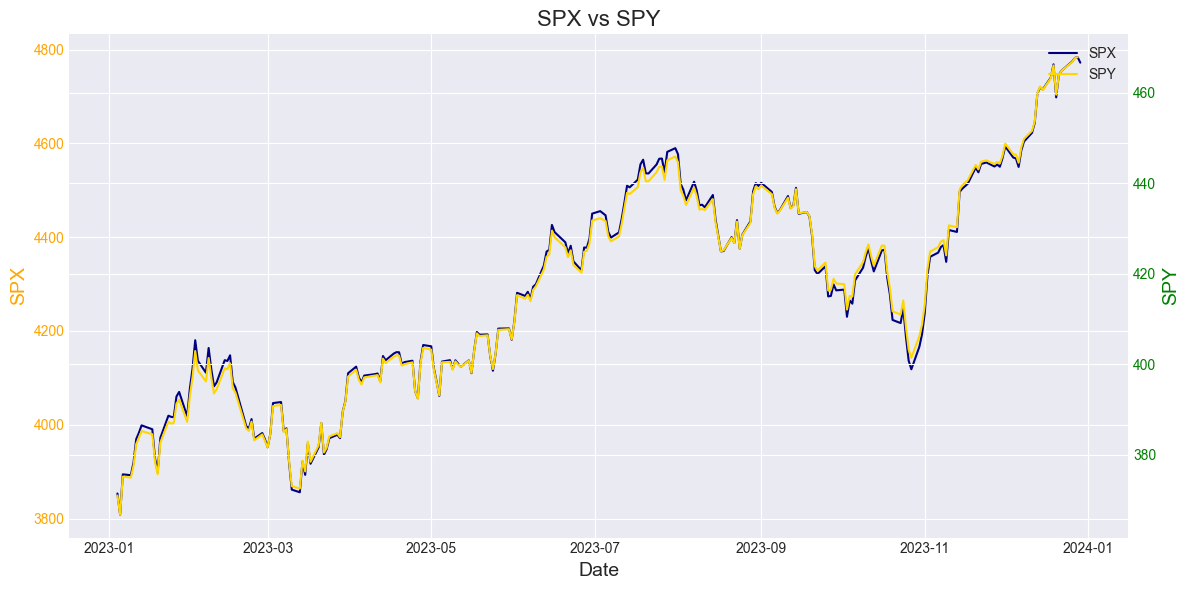

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(options["underlying_last"], color="navy", label="SPX")
ax1.set_ylabel("SPX", color="orange", fontsize=14)
ax1.tick_params(axis='y', labelcolor="orange")

ax2 = ax1.twinx()
ax2.plot(spy["Close"], color="gold", label="SPY")
ax2.set_ylabel("SPY", color="gold", fontsize=14)
ax2.tick_params(axis='y', labelcolor="green")

ax1.set_title("SPX vs SPY", fontsize=16)
ax1.set_xlabel("Date", fontsize=14)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()

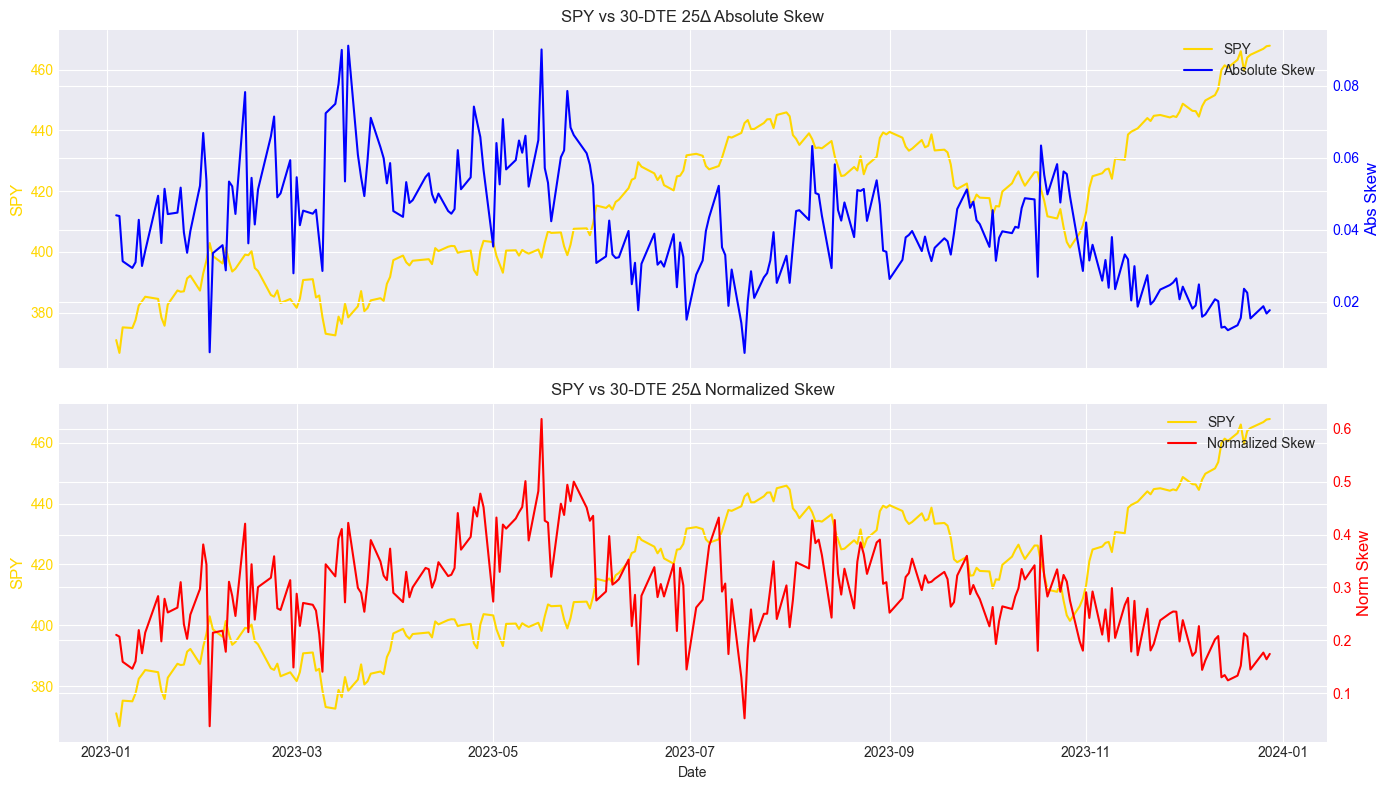

In [28]:
common_dates = synthetic_skew.index.intersection(spy.index)
synthetic_skew = synthetic_skew.loc[common_dates]
synthetic_skew.index.name = 'date'

spy = spy.loc[common_dates]
spy.index.name = 'date'

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- First subplot: SPY vs Absolute Skew ---
ax1 = axes[0]
ax1.plot(spy["Close"], color="gold", label="SPY")
ax1.set_ylabel("SPY", color="gold", fontsize=12)
ax1.tick_params(axis='y', labelcolor="gold")
ax1.set_title("SPY vs 30-DTE 25Δ Absolute Skew")

ax1b = ax1.twinx()
ax1b.plot(synthetic_skew["skew_abs"], color="blue", label="Absolute Skew")
ax1b.set_ylabel("Abs Skew", color="blue", fontsize=12)
ax1b.tick_params(axis='y', labelcolor="blue")

lines1, labels1 = ax1.get_legend_handles_labels()
lines1b, labels1b = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines1b, labels1 + labels1b, loc="upper right")

# --- Second subplot: SPY vs Normalized Skew ---
ax2 = axes[1]
ax2.plot(spy["Close"], color="gold", label="SPY")
ax2.set_ylabel("SPY", color="gold", fontsize=12)
ax2.tick_params(axis='y', labelcolor="gold")
ax2.set_title("SPY vs 30-DTE 25Δ Normalized Skew")
ax2.set_xlabel("Date")

ax2b = ax2.twinx()
ax2b.plot(synthetic_skew["skew_norm"], color="red", label="Normalized Skew")
ax2b.set_ylabel("Norm Skew", color="red", fontsize=12)
ax2b.tick_params(axis='y', labelcolor="red")

lines2, labels2 = ax2.get_legend_handles_labels()
lines2b, labels2b = ax2b.get_legend_handles_labels()
ax2.legend(lines2 + lines2b, labels2 + labels2b, loc="upper right")

plt.tight_layout()
plt.show()

As you can see, large increases in the stock price often coincide with sharp declines in skew. Conversely, when the price falls, the skew tends to rise rapidly, reflecting heightened demand for downside protection.

In [29]:
corr_norm = np.corrcoef(spy["Close"].to_numpy().flatten(), 
                   synthetic_skew["skew_norm"].to_numpy().flatten())[0, 1]

corr_abs = np.corrcoef(spy["Close"].to_numpy().flatten(), 
                   synthetic_skew["skew_abs"].to_numpy().flatten())[0, 1]

print(f"The correlation between the normalized skew and the SPY is: {corr_norm:.2}")
print(f"The correlation between the absolute skew and the SPY is: {corr_abs:.2}")

The correlation between the normalized skew and the SPY is: -0.29
The correlation between the absolute skew and the SPY is: -0.66


As shown, the correlation between SPY and the absolute skew is **more than twice** as strong as with the normalized version, so we can use the skew to take directional trade.

### **Compute the Trading Signal**

When the skew becomes extremely high or low relative to its historical average, it may signal fear or complacency in the market:

- A **high skew Z-score** implies elevated demand for downside protection → potential **market top or correction** ahead.
- A **low skew Z-score** implies low demand for puts → potential **bounce or rally** ahead.


We define the Z-score of the skew as:

$$
Z_t = \frac{\text{Skew}_t - \mu_{\text{Skew}}}{\sigma_{\text{Skew}}}
$$

Where:
- $\text{Skew}_t$ is the skew on day *t*
- $\mu_{\text{Skew}}$ is the rolling mean of the skew
- $\sigma_{\text{Skew}}$ is the rolling standard deviation

In [30]:
def compute_zscore(series, window=60):
    return (series - series.rolling(window).mean()) / series.rolling(window).std()

synthetic_skew["skew_zscore"] = compute_zscore(synthetic_skew["skew_abs"], window=60)

#### **Trading Logic**

- If $Z_t > +1.5$ → Skew is unusually **high** → Market may be near a **top** → **Sell SPY**
- If $Z_t < -1.5$ → Skew is unusually **low** → Market may be **oversold** → **Buy SPY**

This approach assumes skew extremes reflect **excess fear or complacency**, making them useful contrarian signals.

In [31]:
def z_score_strategy(z_score, entry_threshold=2, exit_threshold=0.5, holding_period=5):
    signals = pd.DataFrame(index=z_score.index)
    signals["long"] = False
    signals["short"] = False
    signals["exit"] = False
    signals["position"] = 0

    position = 0  # Current position (1 = long, -1 = short, 0 = no position)
    for i in range(len(z_score)):
        if pd.isna(z_score.iloc[i]):  # Skip NaN values for rolling
            continue

        if position == 0: 
            # Enter long position
            if z_score.iloc[i] < -entry_threshold:
                signals.at[z_score.index[i], "long"] = True
                position = 1
                entry_idx = i
            # Enter short position
            elif z_score.iloc[i] > entry_threshold:
                signals.at[z_score.index[i], "short"] = True
                position = -1 
                entry_idx = i

        elif position != 0: 
            # Exit long position
            if z_score.iloc[i] >= exit_threshold:
                signals.at[z_score.index[i], "exit"] = True
                position = 0
                entry_idx = None

            # Exit short position
            elif z_score.iloc[i] <= -exit_threshold:
                signals.at[z_score.index[i], "exit"] = True
                position = 0
                entry_idx = None  

            # Exit due to holding period
            elif i - entry_idx >= holding_period:
                signals.at[z_score.index[i], "exit"] = True
                position = 0
                entry_idx = None  

        signals.loc[z_score.index[i], "position"] = position

    return signals

signals = z_score_strategy(synthetic_skew["skew_zscore"], entry_threshold=1.5)

In [32]:
spy["position"] = signals["position"].shift(1).fillna(0)  # act on previous day’s signal
spy["spy_returns"] = spy["Close"].pct_change()
spy["strategy_returns"] = spy["position"] * spy["spy_returns"]

spy["cumulative_returns"] = (1 + spy["strategy_returns"]).cumprod()

In [ ]:
def plot_cumul_returns_with_signals(strategy_return, buy_hold_return, z_score, signals, 
                                    entry_threshold=2, exit_threshold=0.5, height=7, width=10):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, height))

    strategy_return = strategy_return.dropna()
    buy_hold_return = buy_hold_return.dropna()
    z_score = z_score.dropna()
    
    common_dates = strategy_return.index \
    .intersection(buy_hold_return.index) \
    .intersection(z_score.index) \
    .intersection(signals.index)

    strategy_return = strategy_return.loc[common_dates]
    buy_hold_return = buy_hold_return.loc[common_dates]
    signals = signals.loc[common_dates]

    # Plot buy and hold vs strategy returns
    ax1.plot(strategy_return.index, (1 + strategy_return).cumprod(), label="Skew Z-Score Strategy")
    ax1.plot(buy_hold_return.index, (1 + buy_hold_return).cumprod(), label="Buy & Hold")
    ax1.legend()
    ax1.set_ylabel("Cumulative Return", fontsize=13)
    ax1.set_title("Cumulative Returns: Skew Z-Score vs Buy & Hold", fontsize=15)
    ax1.grid(True)

    # Plot z-score
    ax2.plot(z_score, label="Z-Score", color="blue", zorder=1)

    # Plot entry and exit thresholds
    ax2.axhline(entry_threshold, color="green", linestyle="--") #,label=f"±{entry_threshold}σ Entry", zorder=2)
    ax2.axhline(-entry_threshold, color="green", linestyle="--", zorder=2)
    ax2.axhline(exit_threshold, color="red", linestyle="--")#, label=f"±{exit_threshold}σ Exit", zorder=2)
    ax2.axhline(-exit_threshold, color="red", linestyle="--", zorder=2)

    # Plot entry/exit points
    long_entries = z_score[signals["long"]]
    short_entries = z_score[signals["short"]]
    exits = z_score[signals["exit"]]

    ax2.scatter(long_entries.index, long_entries, color="lime", label="Long Entry", marker="^", s=50, edgecolors="black", zorder=3)
    ax2.scatter(short_entries.index, short_entries, color="orange", label="Short Entry", marker="v", s=50, edgecolors="black", zorder=3)
    ax2.scatter(exits.index, exits, color="purple", label="Exit", marker="D", s=50, edgecolors="black", zorder=3)

    ax2.set_title("Z-Score Strategy", fontsize=15)
    ax2.set_xlabel("Date", fontsize=13)
    ax2.set_ylabel("Z-Score", fontsize=13)
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

    # TODO: Make this plot take any signal so that there will be 1 + n rows for teh plot 
    # with teh size of the signal being smalelr than the cumul pnl plot

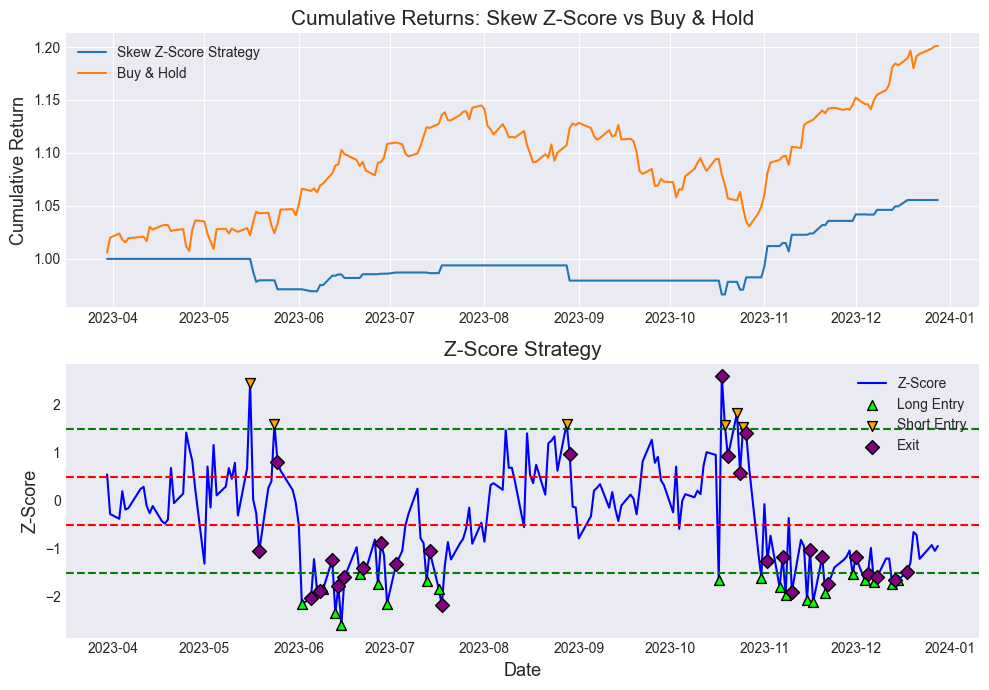

In [57]:
plot_cumul_returns_with_signals(spy["strategy_returns"], spy["spy_returns"],
                                synthetic_skew["skew_zscore"], signals, 1.5, 0.5)

Here is a simple overview of how this z-score signal can be used to enter trade on the underlying. Of course it is not a valid backtest as a proper one would find the best trading paraemetrs (e.g. entry/exit threshold and/or holding period) and would also oinclude real trading constraints, but it is still helpful to see how it can be used in solation to trigger positon.

In additon, usign the Z score only is not perfect as we can see and other filters can be used to remove false positve signals such as IVP or VIX.

Latter on we will build a realistic backtest and analyze the performanc eof the staretegy.

Realistic backtest

	•	Max holding period (e.g. 5–10 days)
	•	Stop-loss / take-profit thresholds (e.g. ±5%)
	•	Signal cooldown windows (e.g. no re-entry for 2 days)

Take a list of signals (or strategies) as paraemetrs, ierate over it in the backtest and if 1/3 of signal say yes enter size to 1, if 2/3 size of 2 if 3/3 siz of 3.